In [162]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [163]:
%env DETECTRON2_DATASETS=../data/datasets

env: DETECTRON2_DATASETS=../data/datasets


<IPython.core.display.Javascript object>

In [164]:
# Setup path
import os
import sys

sys.path.append(os.path.normpath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.normpath(os.path.join(os.getcwd(), "..", "external", "MiDaS")))

<IPython.core.display.Javascript object>

In [177]:
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()
from detectron2.modeling import build_model
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
    DatasetMapper,
)
from detectron2.checkpoint import DetectionCheckpointer
import matplotlib.pyplot as plt
import torch
import detectron2.data.transforms as T
from detectron2.utils.visualizer import Visualizer

<IPython.core.display.Javascript object>

In [166]:
from midas_hkrm.utils import construct_config
import midas_hkrm.objects

<IPython.core.display.Javascript object>

In [167]:
cfg = construct_config()
# best found model in terms of AP on the test set
cfg.MODEL.WEIGHTS = (
    "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/output/model_0254999.pth"
)
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

<IPython.core.display.Javascript object>

In [168]:
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
)

<IPython.core.display.Javascript object>

In [169]:
def extract_features_and_transformed_features(model_input):

    with torch.no_grad():
        preprocessed_images = model.preprocess_image(model_input)

        # Backbone
        features = model.backbone(preprocessed_images.tensor)

        # Proposals
        proposals, _ = model.proposal_generator(preprocessed_images, features, None)

        # Final instances
        instances, _ = model.roi_heads(preprocessed_images, features, proposals)
        instances_r = [
            x["instances"]
            for x in model._postprocess(
                instances, model_input, preprocessed_images.image_sizes
            )
        ]

        object_features = [features[f] for f in model.roi_heads.in_features]
        object_features = model.roi_heads.box_pooler(
            object_features, [x.pred_boxes for x in instances]
        )

        base_features = model.roi_heads.box_head.base_box_head(object_features)
        transformed_f = model.roi_heads.box_head(object_features, instances)

        return instances[0], base_features, transformed_f

<IPython.core.display.Javascript object>

In [170]:
data = DatasetCatalog["coco_2017_train"]()

[01/06 14:34:46 d2.data.datasets.coco]: Loading ../data/datasets/coco/annotations/instances_train2017.json takes 29.47 seconds.
[01/06 14:34:48 d2.data.datasets.coco]: Loaded 118287 images in COCO format from ../data/datasets/coco/annotations/instances_train2017.json


<IPython.core.display.Javascript object>

In [179]:
dataset = build_detection_test_loader(
    dataset=data,
    mapper=DatasetMapper(cfg, is_train=False),
    sampler=torch.utils.data.RandomSampler(data),
)

[01/06 14:40:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 14:40:32 d2.data.common]: Serializing 118287 elements to byte tensors and concatenating them all ...
[01/06 14:40:37 d2.data.common]: Serialized dataset takes 452.24 MiB


<IPython.core.display.Javascript object>

In [180]:
loader = iter(dataset)

<IPython.core.display.Javascript object>

In [190]:
batch = next(loader)

<IPython.core.display.Javascript object>

In [191]:
instances, base_features, transformed_f = extract_features_and_transformed_features(
    batch
)

<IPython.core.display.Javascript object>

In [192]:
v = Visualizer(
    batch[0]["image"].cpu().numpy().transpose(1, 2, 0)[:, :, ::-1],
    MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
    scale=2,
)
out = v.draw_instance_predictions(instances.to("cpu"))

<IPython.core.display.Javascript object>

In [153]:
# plt.figure(figsize=(10, 10))
# plt.imshow(out.get_image())

<IPython.core.display.Javascript object>

In [193]:
base_features = base_features.numpy()
transformed_f = transformed_f.numpy()

<IPython.core.display.Javascript object>

In [194]:
metadata = MetadataCatalog["coco_2017_train"]

<IPython.core.display.Javascript object>

In [195]:
classes = metadata.thing_classes

<IPython.core.display.Javascript object>

In [196]:
detected_classes = [classes[i] for i in instances.pred_classes]

<IPython.core.display.Javascript object>

In [197]:
from sklearn.decomposition import PCA
import seaborn as sns

<IPython.core.display.Javascript object>

In [198]:
base_features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.49812913, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

<IPython.core.display.Javascript object>

In [199]:
trans_b = PCA(n_components=2).fit_transform(base_features)

<IPython.core.display.Javascript object>

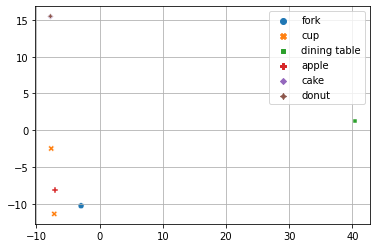

<IPython.core.display.Javascript object>

In [200]:
sns.scatterplot(
    x=trans_b[:, 0], y=trans_b[:, 1], hue=detected_classes, style=detected_classes
)
plt.grid(True)
plt.show()

In [201]:
trans = PCA(n_components=2).fit_transform(transformed_f)

<IPython.core.display.Javascript object>

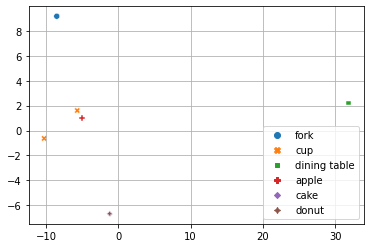

<IPython.core.display.Javascript object>

In [202]:
sns.scatterplot(
    x=trans[:, 0], y=trans[:, 1], hue=detected_classes, style=detected_classes
)
plt.grid(True)
plt.show()

In [149]:
base_features == transformed_f

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

<IPython.core.display.Javascript object>

In [229]:
num_images = 10

<IPython.core.display.Javascript object>

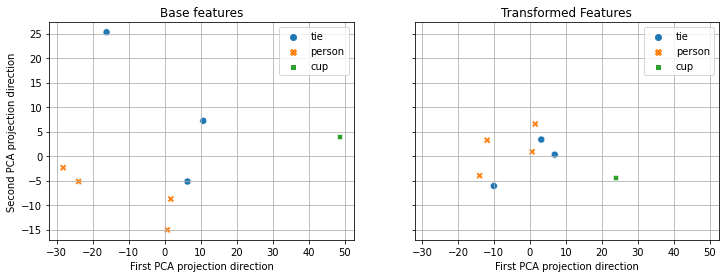

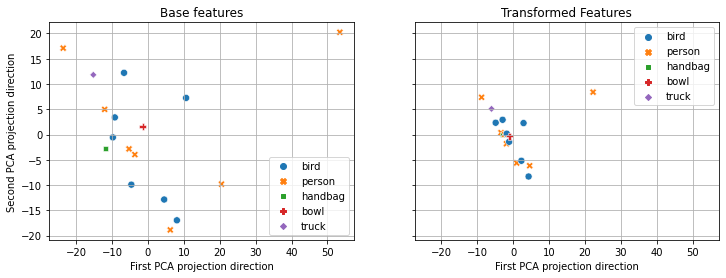

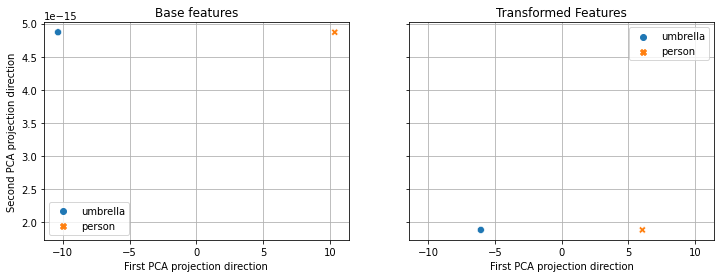

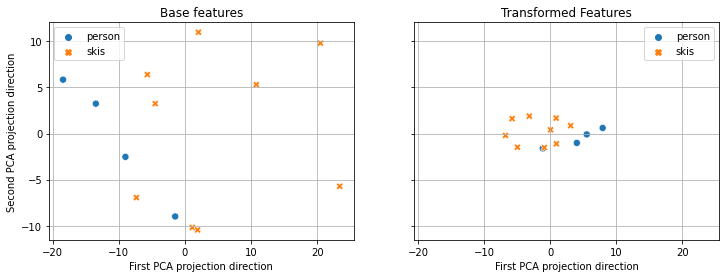

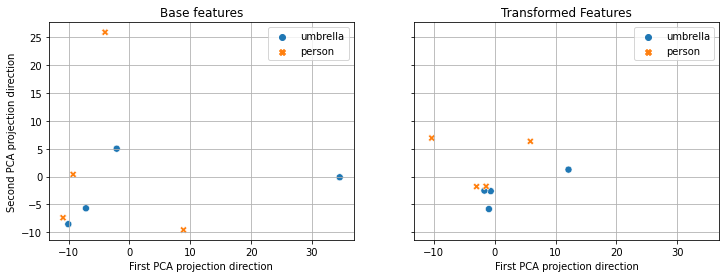

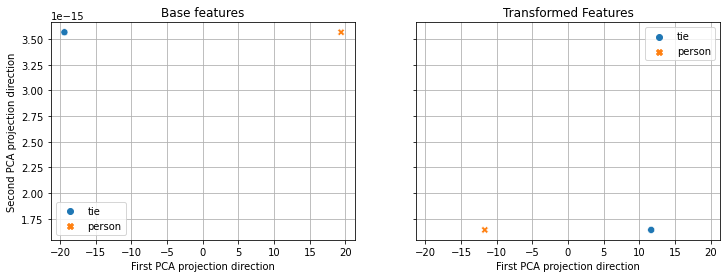

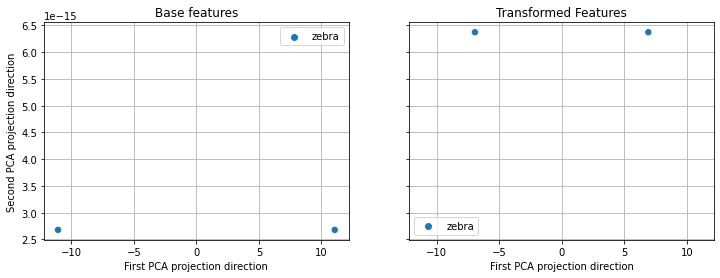

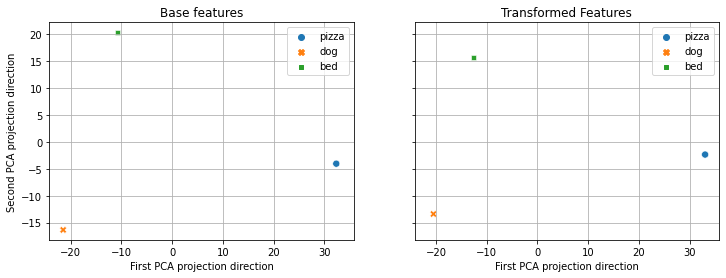

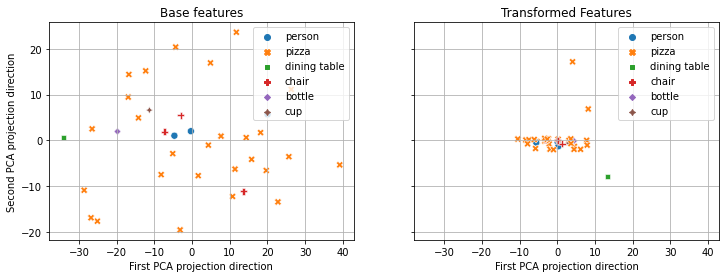

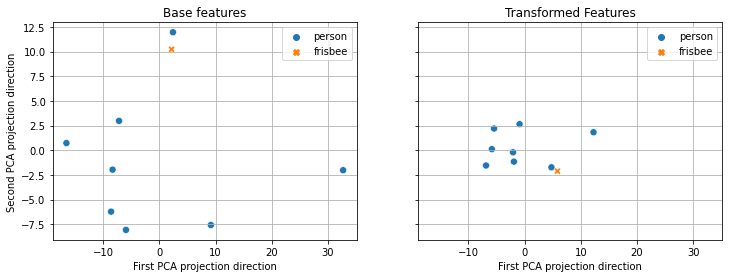

<IPython.core.display.Javascript object>

In [230]:
c = 0
while c < num_images:
    sample = next(loader)
    instances, base_f, transformed_f = extract_features_and_transformed_features(sample)
    if len(base_f) < 2:
        continue
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))

    detected_classes = [classes[i] for i in instances.pred_classes]
    pca_base_f = PCA(n_components=2).fit_transform(base_f)
    pca_trans_f = PCA(n_components=2).fit_transform(transformed_f)
    sns.scatterplot(
        x=pca_base_f[:, 0],
        y=pca_base_f[:, 1],
        hue=detected_classes,
        style=detected_classes,
        s=50,
        ax=axs[0],
    )
    sns.scatterplot(
        x=pca_trans_f[:, 0],
        y=pca_trans_f[:, 1],
        hue=detected_classes,
        style=detected_classes,
        s=50,
        ax=axs[1],
    )
    axs[0].grid(True)
    axs[1].grid(True)
    axs[0].set_title("Base features")
    axs[1].set_title("Transformed Features")
    axs[0].set_xlabel("First PCA projection direction")
    axs[0].set_ylabel("Second PCA projection direction")
    axs[1].set_xlabel("First PCA projection direction")
    axs[1].set_ylabel("Second PCA projection direction")
    #     fig.show()
    #     save = input()
    #     if save == "yes":
    c += 1
    fig.savefig(f"pca{c}.jpg")